Disclaimer: Kindly be aware that the questions and datasets featured in this tutorial were originally presented by [Ryan Abernathy in "An Introduction to Earth and Environmental Data Science"](https://earth-env-data-science.github.io/intro.html).

# Making Maps with Cartopy

NARR is NCEP's [North American Regional Reanalysis](https://www.esrl.noaa.gov/psd/data/gridded/data.narr.html), a widely used product for studying the weather and climate of the continental US. The data is available from NOAA's [Earth System Research Laboratory](https://www.esrl.noaa.gov/) via [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP), meaing that xarray can open the data "remotely" without downloading a file.

    

In [1]:
#scientific computing
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

#mapping
import cartopy.crs as ccrs
import cartopy as cp

# default params of notebook
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'
%xmode Minimal

import warnings
warnings.filterwarnings('ignore')

Exception reporting mode: Minimal


### 1) Plot data from NARR
NARR is NCEP's [North American Regional Reanalysis](https://www.esrl.noaa.gov/psd/data/gridded/data.narr.html), a widely used product for studying the weather and climate of the continental US. The data is available from NOAA's [Earth System Research Laboratory](https://www.esrl.noaa.gov/) via [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP), meaing that xarray can open the data "remotely" without downloading a file.

geopential height file:

    https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/pressure/hgt.201810.nc
    
precipitation file:

    https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/apcp.2018.nc
    
Our goal will be to recreate the plot below.

![narr_map](https://earth-env-data-science.github.io/_images/narr_map.png)

#### Loading the datasets

In [2]:
geo_url = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/pressure/hgt.201810.nc'

geo_potential = xr.open_dataset(geo_url, drop_variables=['time_bnds'] )
geo_potential

<xarray.Dataset>
Dimensions:            (time: 31, level: 29, y: 277, x: 349)
Coordinates:
  * time               (time) datetime64[ns] 2018-10-01 ... 2018-10-31
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Data variables:
    Lambert_Conformal  int32 ...
    hgt                (time, level, y, x) float32 ...
Attributes: (12/17)
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    ...                              ...
    title:                           Daily NARR
    history:                         created Sat Mar 26 07:07:59 MDT 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
prcp_url = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/apcp.2018.nc'
prcp = xr.open_dataset(prcp_url, drop_variables=['time_bnds'] )
prcp

<xarray.Dataset>
Dimensions:            (time: 365, y: 277, x: 349)
Coordinates:
  * time               (time) datetime64[ns] 2018-01-01 ... 2018-12-31
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Data variables:
    Lambert_Conformal  int32 ...
    apcp               (time, y, x) float32 ...
Attributes: (12/17)
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    ...                              ...
    title:                           Daily NARR
    history:                         created Sat Mar 26 04:56:06 MDT 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    DODS_EXTRA.Unlimited_Dimension:  time

With the datasets loaded, we can now use the `sel()` function to slice the dataset at the specified time. 

In [6]:
geo_potential_slice = geo_potential.sel(time='2018-10-15', level=500).hgt

prcp_slice_total = prcp.sel(time='2018-10-15').apcp

Let's start the preparation to construct our map. Note the Lambert_Conformal within our variables. This variable defines the type of projection we'll utilize and the necessary parameters for its construction. This specific projection requires values for central latitude and longitude, as well as parameters for false easting and northing. I highly recommend reviewing `cartopy` projections [here](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html).

In [7]:
#map setup
cen_lon = prcp.Lambert_Conformal.attrs.get('longitude_of_central_meridian')
cen_lat = prcp.Lambert_Conformal.attrs.get('latitude_of_projection_origin')

false_easting = prcp.Lambert_Conformal.attrs.get('false_easting')
false_northing = prcp.Lambert_Conformal.attrs.get('false_northing')

lambert_conformal = ccrs.LambertConformal(central_longitude=cen_lon, 
                                          central_latitude=cen_lat, 
                                          false_easting = false_easting,
                                          false_northing= false_northing)


With the Lambert Conformal projection parameters set, we're ready to construct the plot. With a `cartopy` project set, we get a `GeoAxes` object for plotting. We can then define the map's extent by using `set_extent([min_lon, max_lon, min_lat, max_lat])`.

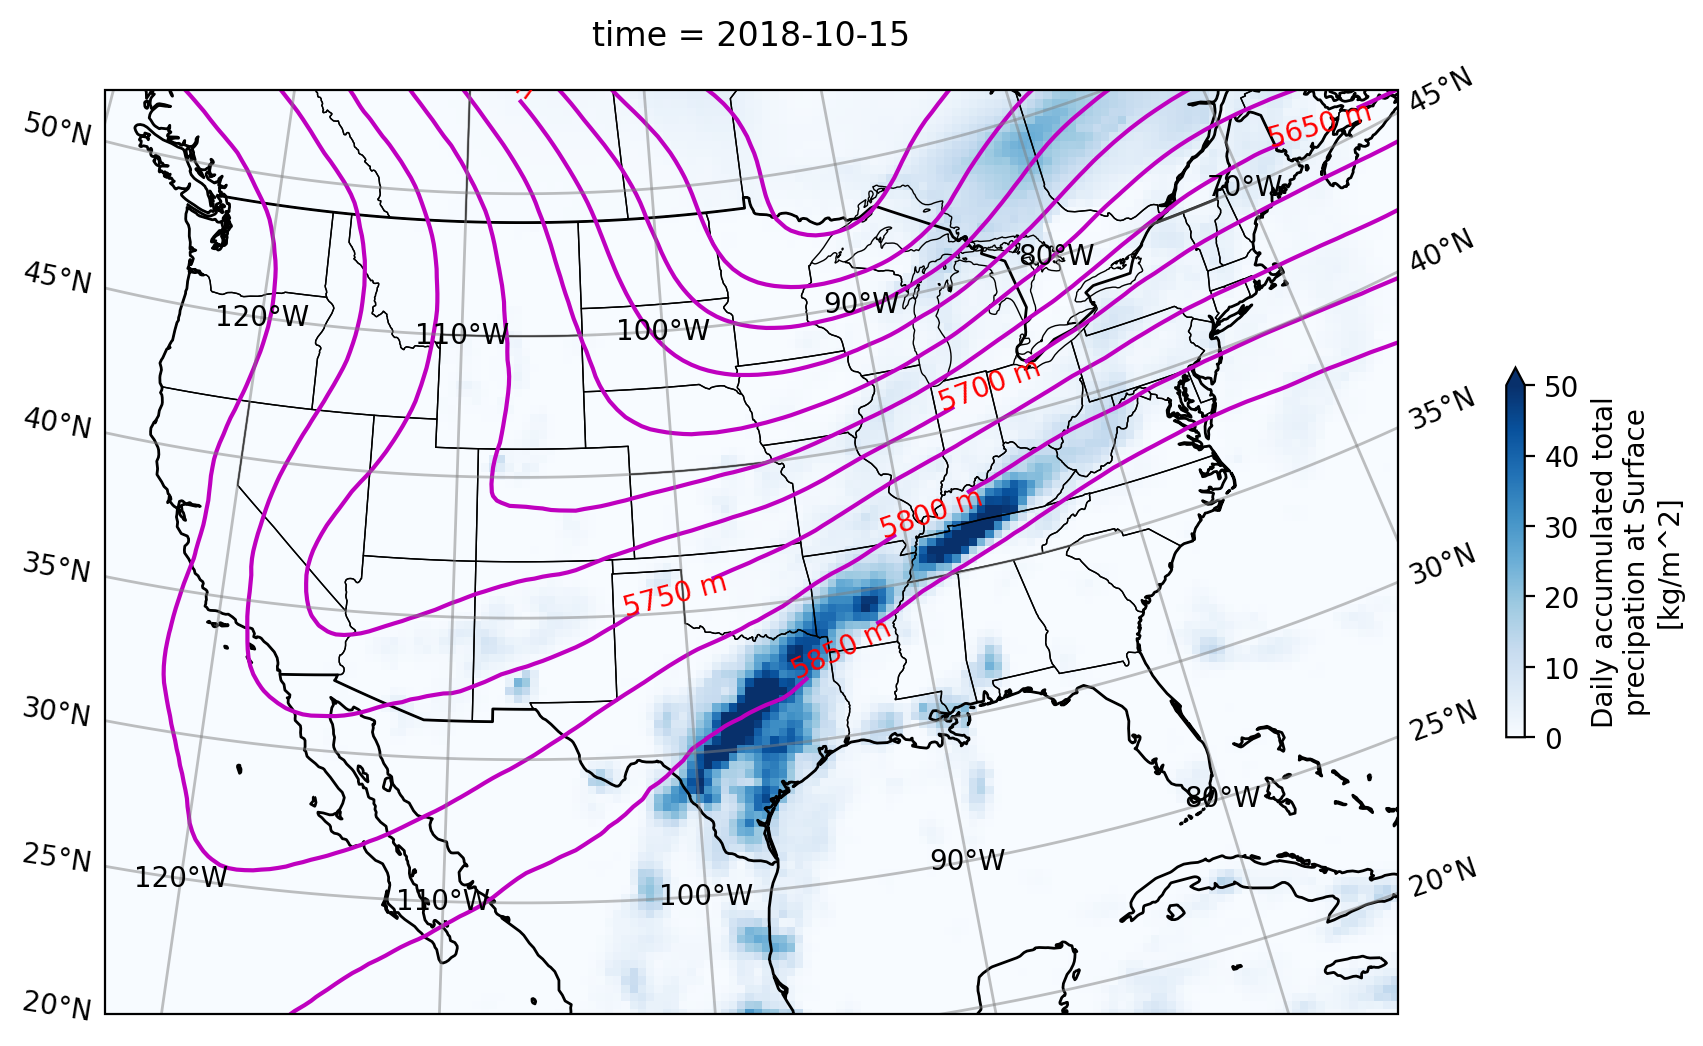

In [29]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=lambert_conformal)
ax.set_extent([-122,-75, 20,50])


# Plot states & borders
ax.add_feature(cp.feature.STATES, edgecolor='black', linewidth=0.5)
ax.add_feature(cp.feature.BORDERS, edgecolor='black', linewidth=1)
ax.coastlines()

#contour set up
levels=np.arange(5000,5900,50)
geo_contour = geo_potential_slice.plot.contour(ax=ax, 
                                               transform=lambert_conformal,
                                               levels=levels,
                                               colors='m')

ax.clabel(geo_contour, inline=True, fmt='%d m', colors='r')

#pcolormesh set up
cbar_kwargs= {'shrink': 0.4,
              'label':'Daily accumulated total\nprecipation at Surface\n[kg/m^2]'
             }
prcp_mesh = prcp_slice_total.plot.pcolormesh(ax=ax, 
                                              transform=lambert_conformal,
                                              cmap='Blues',vmax=50,
                                              cbar_kwargs=cbar_kwargs
                                             )


ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray',alpha=0.5, linestyle='-')


plt.show()

##### Code Explanation 

1) We define the figure area, setting the projection and extent of coverage:
```python
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=lambert_conformal)
ax.set_extent([-122, -75, 20, 50])
```

2) Having prepared the figure, we add features to the map. We utilize `cartopy.feature` to incorporate states and borders onto the map, and `coastlines` to outline bodies of water.
```python
ax.add_feature(cp.feature.STATES, edgecolor='black', linewidth=0.5)
ax.add_feature(cp.feature.BORDERS, edgecolor='black', linewidth=1)
ax.coastlines()
```

3) Let's now plot data on our map. First, we set up the contours. Pay attention to the range of geopotential height values. Then, we proceed to plot the precipitation. Here, we create a dictionary for customizations for the color bar and supplying it to the `plot.pcolormesh` function.
```python
# Contour setup
levels = np.arange(5000, 5900, 50)
geo_contour = geo_potential_slice.plot.contour(ax=ax,
                                               transform=lambert_conformal,
                                               levels=levels,
                                               colors='m')

ax.clabel(geo_contour, inline=True, fmt='%d m', colors='r')

# Pcolormesh setup
cbar_kwargs = {'shrink': 0.4,
               'label': 'Daily accumulated total\nprecipitation at Surface\n[kg/m^2]'
              }
prcp_mesh = prcp_slice_total.plot.pcolormesh(ax=ax,
                                             transform=lambert_conformal,
                                             cmap='Blues', vmax=50,
                                             cbar_kwargs=cbar_kwargs
                                            )
```

4) Lastly, we set up the gridlines. Note that only `ccrs.PlateCaree()` is available for this function.
```python
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='-')
plt.show()
```
<br>
<br>
<br>

### 2) Antarctic Sea Ice

Download this file and then use it to plot the concentration of Antarctic Sea Ice on Aug. 7, 2017. Again, you will need to explore the file contents in order to determine the correct projection.

![sea_ice_map](https://earth-env-data-science.github.io/_images/sea_ice_map.png)


In [21]:
import xarray as xr
import pooch
url = 'https://polarwatch.noaa.gov/erddap/files/nsidcCDRiceSQsh1day/2017/seaice_conc_daily_sh_f17_20170807_v03r01.nc'
fname = pooch.retrieve(url, known_hash='19b74e7e97f1c0786da0c674c4d5e4af0da5b32e2fe8c66a8f1a8a9a1241e73c')
ds_ice = xr.open_dataset(fname, drop_variables='melt_onset_day_seaice_conc_cdr')
ds_ice

<xarray.Dataset>
Dimensions:                     (time: 1, ygrid: 332, xgrid: 316)
Coordinates:
  * time                        (time) datetime64[ns] 2017-08-07T12:00:00
  * ygrid                       (ygrid) float32 4.338e+06 ... -3.938e+06
  * xgrid                       (xgrid) float32 -3.938e+06 ... 3.938e+06
    latitude                    (ygrid, xgrid) float64 ...
    longitude                   (ygrid, xgrid) float64 ...
Data variables:
    projection                  |S1 ...
    seaice_conc_cdr             (time, ygrid, xgrid) float32 ...
    stdev_of_seaice_conc_cdr    (time, ygrid, xgrid) float32 ...
    qa_of_seaice_conc_cdr       (time, ygrid, xgrid) float32 ...
    goddard_merged_seaice_conc  (time, ygrid, xgrid) float32 ...
    goddard_nt_seaice_conc      (time, ygrid, xgrid) float32 ...
    goddard_bt_seaice_conc      (time, ygrid, xgrid) float32 ...
Attributes: (12/70)
    references:                             Comiso, J. C., and F. Nishio. 200...
    program:                                NOAA Climate Data Record Program
    cdr_variable:                           seaice_conc_cdr
    software_version_id:                    git@bitbucket.org:nsidc/seaice_cd...
    Metadata_Link:                          https://nsidc.org/api/dataset/met...
    product_version:                        v03r01
    ...                                     ...
    scaling_factor:                         1.0
    false_easting:                          0.0
    false_northing:                         0.0
    semimajor_radius:                       6378273.0
    semiminor_radius:                       6356889.449
    proj_units:                             meters

Let's take a look at the metadata

In [23]:
#loop through the variables
for variable in ds_ice.variables:
    #get the long name from attributes
    long_name = ds_ice[variable].attrs.get("long_name",'')
    print(f"{variable} -- {long_name}.")
    print()

projection -- .

seaice_conc_cdr -- NOAA/NSIDC Climate Data Record of Passive Microwave Daily Southern Hemisphere Sea Ice Concentration.

stdev_of_seaice_conc_cdr -- Passive Microwave Daily Southern Hemisphere Sea Ice Concentration Source Estimated Standard Deviation.

qa_of_seaice_conc_cdr -- Passive Microwave Daily Southern Hemisphere Sea Ice Concentration QC flags.

goddard_merged_seaice_conc -- Goddard Edited Climate Data Record of Passive Microwave Daily Southern Hemisphere Sea Ice Concentration, Goddard Edited.

goddard_nt_seaice_conc -- Passive Microwave Daily Southern Hemisphere Sea Ice Concentration by NASA Team algorithm with Goddard QC.

goddard_bt_seaice_conc -- Passive Microwave Daily Southern Hemisphere Sea Ice Concentration by Bootstrap algorithm with Goddard QC.

time -- Centered Time.

ygrid -- projection_grid_y_centers.

xgrid -- projection_grid_x_centers.

latitude -- latitude.

longitude -- longitude.



Now to make the plot

zorder introduced - the position of the layer in reference to the other layers

50eo

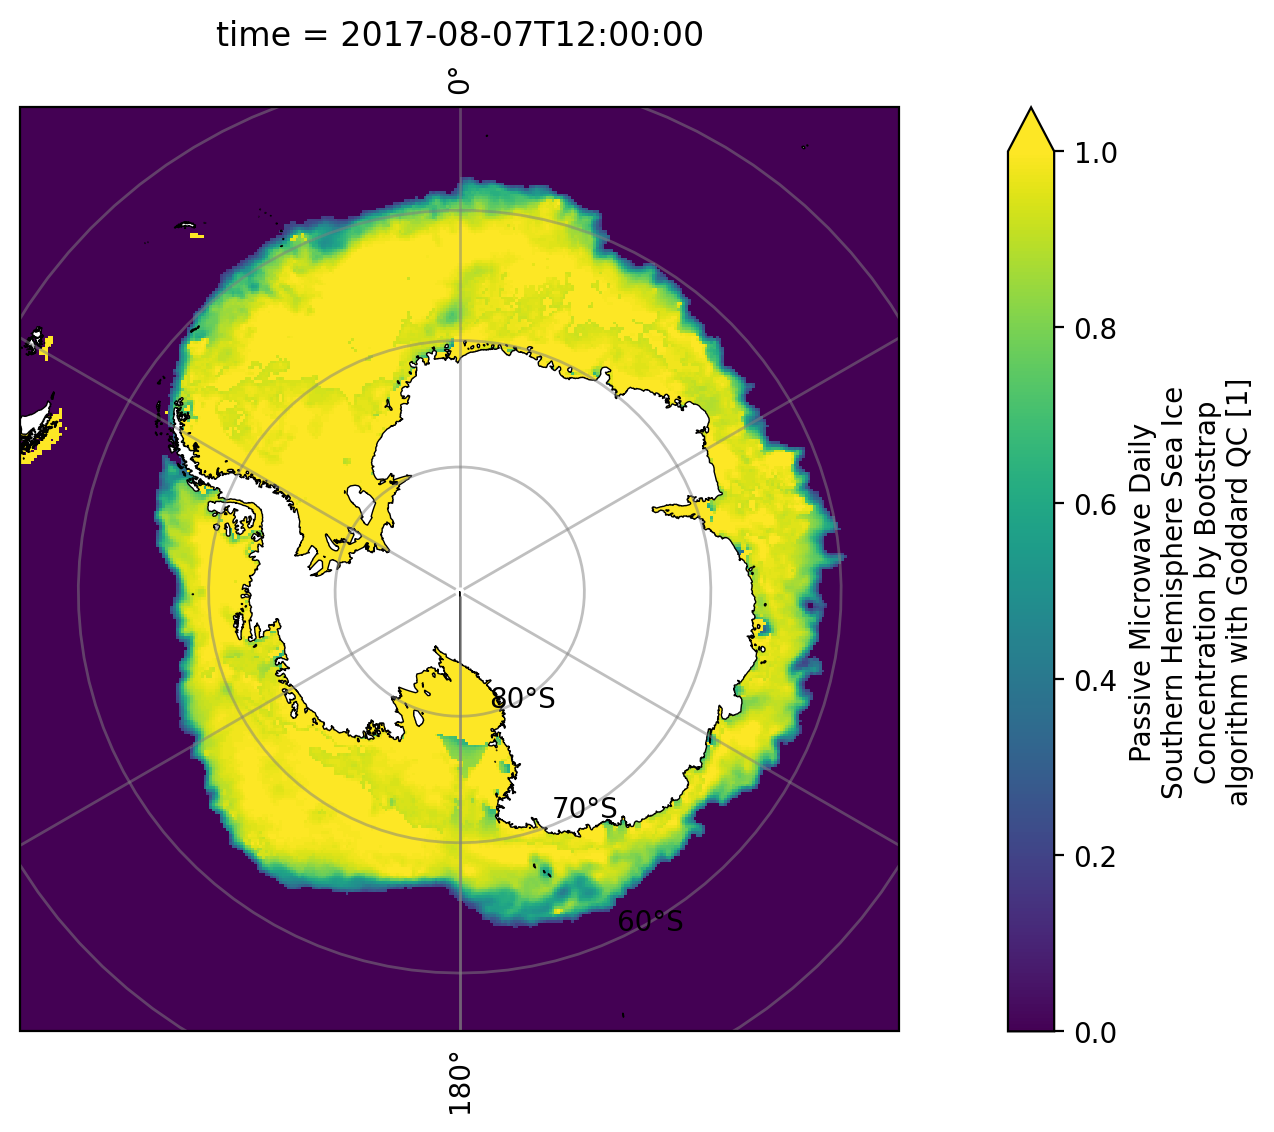

In [84]:

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

#ax.coastlines(zorder=3)
ax.add_feature(cp.feature.LAND.with_scale('10m'), facecolor='white', edgecolor='black', linewidth=0.5)

ds_ice.goddard_bt_seaice_conc.sel(time='2017-08-07').plot(ax=ax,
                                                          vmax=1,
                                                          zorder=-2,
                                                          transform=ccrs.SouthPolarStereo())

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray',alpha=0.5, linestyle='-')

### 3) Global USGS Earthquakes

Reload the file we explored in homework 5 using pandas

    http://www.ldeo.columbia.edu/~rpa/usgs_earthquakes_2014.csv
    
and use the data to recreate this map.

![earthquake_map](https://earth-env-data-science.github.io/_images/earthquake_map.png)